In [383]:
from GPControl import *
from globalVar import *

In [387]:
#create X_{T-1} to X_T
X_prev = np.concatenate((X_prev1,X_prev2,X_prev3))
I_next = np.concatenate((I_next1,I_next2,I_next3))
    ### HERE I USE DEFAUTL NOISE EACH STEP
# E[V(t+1) | X_t-1 = x_(t-1)]
global Model ; Model = [None] * (nstep)
gpMdl = None
ctrl = None
ctrlModel = [None] * (nstep)
V_opt_start = None
B_opt_start = None
Model[nstep-1] = finalCost


# n-1-th step exact computation
demandMatrix = demandSimulate(alpha, m0, sigma, 1, len(X_prev), dt, X_prev);
optimal_B = np.zeros(len(X_prev))

## Parallel Optimize B* as function of(Xt-1,I)
LB = np.maximum(B_min, (-I_next)/dt)
UB = np.minimum(B_max, (I_max-I_next)/dt)
sample_num = len(X_prev)
args =[(one_step_objective,demandMatrix[i,1],I_next[i],finalCost,LB[i],UB[i]) for i in range(sample_num)]
p = Pool()
optimal_B = np.array(p.map(minimize,args))
#idx = 0
#for arg in args:
    #optimal_B[idx] = minimize(arg)
    #idx+=1

gp_test = np.column_stack((demandMatrix[:,1], I_next + optimal_B *dt))
costNext = np.abs((demandMatrix[:,1]+optimal_B)**2) *dt + finalCost(gp_test[:,1])


In [402]:
optimal_B

array([ 2.5       ,  1.25270097,  2.5       , ..., -1.28350612,
       -0.57399728,  0.03125   ])

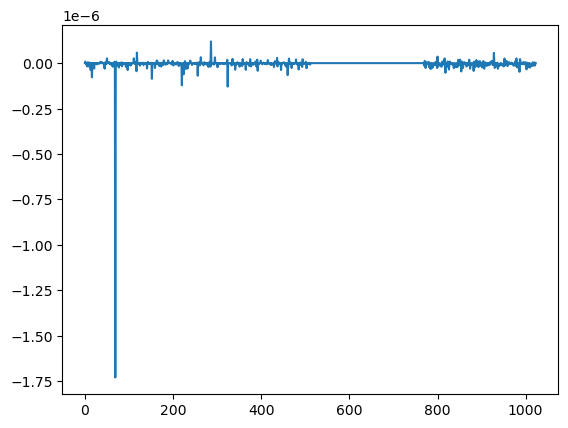

In [422]:
plt.plot(optimal_B-optimal_B_new)

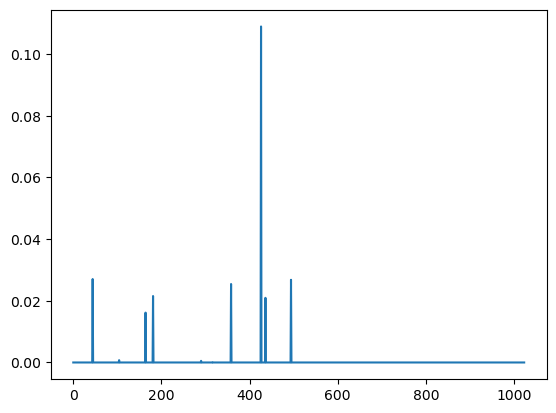

In [393]:
plt.plot(optimal_B-optimal_B_new)

In [440]:
from scipy import optimize

def one_step_objective(B,X,I,mdl):
    next_step = np.array([X,I +B[0]*dt])
    if mdl ==  finalCost:
        objective_func = np.abs((X+B[0])**2) * dt  + finalCost(next_step[1])
    else:
        objective_func = np.abs((X+B[0])**2) * dt + mdl.predict(next_step.reshape(1,-1))[0].flatten()[0]
    return objective_func

def one_step_derivative(B,X,I,mdl):
    next_step = np.array([X,I +B[0]*dt])

    objective_der = 2 * (X+B[0]) * dt + mdl.predictive_gradients(next_step.reshape(1,-1))[0][:,1].flatten()[0] * dt
    return objective_der

def minimize(args):
    f,grad_f,x,i,mdl,lb,ub = args
    bnds = optimize.Bounds(lb, ub )
    res = optimize.minimize(f,jac = grad_f, x0=(lb+ub)/2, args=(x,i,mdl),method = "L-BFGS-B", bounds = bnds)
    return res.x[0]

In [424]:
args =[(one_step_objective,one_step_derivative,demandMatrix[i,1],I_next[i],finalCost,LB[i],UB[i]) for i in range(sample_num)]
p = Pool()
optimal_B_new = np.array(p.map(minimize,args))

In [425]:
import GPy

In [426]:
kernel =  GPy.kern.Matern52(ARD = True, input_dim=2)

X_train = np.column_stack((X_prev, I_next))
y_train = costNext
# E[V_t given X_t-1,I_t]

gpMdl =  GPy.models.GPRegression(X_train,y_train.reshape(-1,1),kernel=kernel)
gpMdl.optimize(start = V_opt_start)
V_opt_start = gpMdl.param_array
print("Values:")
gpMSE = (y_train-gpMdl.predict(X_train)[0].flatten())**2
print(np.mean(gpMSE))
print(gpMdl.param_array)

# assuming we generated, X_t-2,I_t-1
# create path from X_t-2 to X_t-1, then. we optimize on X_t-1, I_t-1+ Bt dt with V_t to get V_t-1
demandMatrix = demandSimulate(alpha, m0, sigma, 1, len(X_prev), dt, X_prev);
optimal_B = np.zeros(len(X_prev))

## Parallel Optimize B* as function of(Xt-1,I)
LB = np.maximum(B_min, (-I_next)/dt)
UB = np.minimum(B_max, (I_max-I_next)/dt)
sample_num = len(X_prev)
args =[(one_step_objective,demandMatrix[i,1],I_next[i],gpMdl,LB[i],UB[i]) for i in range(sample_num)]


 /Users/taung/miniconda3/envs/energy_mike/lib/python3.10/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide
 /Users/taung/miniconda3/envs/energy_mike/lib/python3.10/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/taung/miniconda3/envs/energy_mike/lib/python3.10/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/taung/miniconda3/envs/energy_mike/lib/python3.10/site-packages/GPy/kern/src/stationary.py:581: RuntimeWarning:invalid value encountered in multiply
 /Users/taung/miniconda3/envs/energy_mike/lib/python3.10/site-packages/GPy/kern/src/stationary.py:584: RuntimeWarning:invalid value encountered in subtract


Values:
0.3500603668899357
[5.11949702e+04 3.85826086e+02 2.16943536e+00 3.84845585e-01]


In [441]:
args =[(one_step_objective,one_step_derivative,demandMatrix[i,1],I_next[i],gpMdl,LB[i],UB[i]) for i in range(sample_num)]


In [442]:

idx = 0

for arg in args:
    optimal_B[idx] = minimize(arg)
    idx+=1

In [427]:
args =[(one_step_objective,one_step_derivative,demandMatrix[i,1],I_next[i],gpMdl,LB[i],UB[i]) for i in range(sample_num)]

In [318]:
obs = np.column_stack((demandMatrix[:,1],I_next))

In [319]:
def func(B,obs):
    next_step = np.array([obs[0],obs[1] +B*dt])
    return np.abs((obs[0]+B)**2) * dt + gpMdl.predict(next_step.reshape(1,-1))[0].flatten()[0]

def func_der(B,obs):
    next_step = np.array([obs[0],obs[1] +B*dt])
    return 2* (obs[0]+B) * dt +  gpMdl.predictive_gradients(next_step.reshape(1,-1))[0][:,1].flatten()[0] *dt


In [366]:
B_range = np.linspace(-2.5,2.5,1000)
row = 873
costs = np.zeros(len(B_range))
der_cost = np.zeros(len(B_range))
for i in range(len(costs)):
    costs[i] = func(B_range[i],obs[row,:])
    der_cost[i] = func_der(B_range[i],obs[row,:])

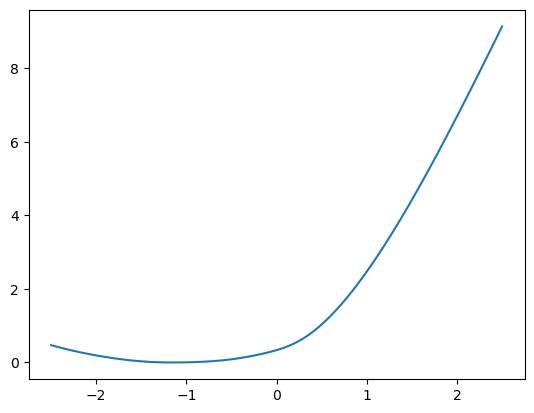

In [367]:
import matplotlib.pyplot as plt

plt.plot(B_range,costs)

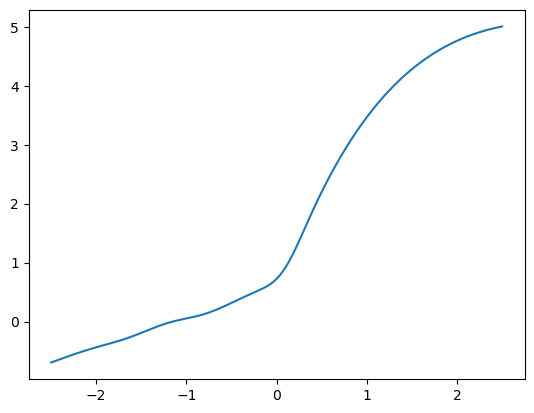

In [368]:
plt.plot(B_range,der_cost)

In [356]:
#np.argwhere(np.abs(der_cost)<=0.1)

In [369]:
optimal_B_new[row] 

-1.1525786782677603

In [370]:
optimal_B[row] 

-1.0312499992656041

In [371]:
obs[row,:]

array([1.14340856, 9.890625  ])

In [328]:
signi = np.argwhere(np.abs(optimal_B-optimal_B_new)>=0.1).flatten()

In [329]:
signi

array([  13,  211,  220,  459,  481,  793,  821,  833,  835,  873,  947,
        998, 1017])

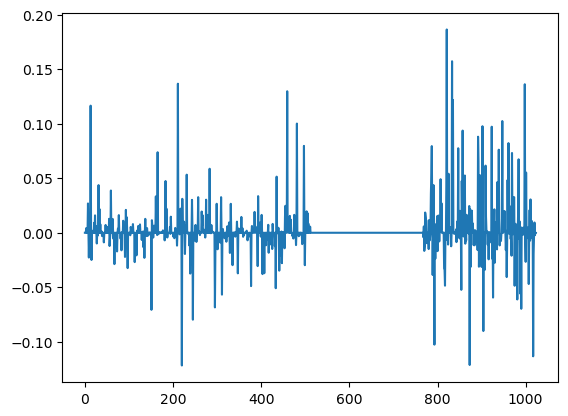

In [327]:
plt.plot(optimal_B_new-optimal_B)

In [6]:
import numpy as np
import GPy

In [53]:
kern1 = GPy.kern.RBF(input_dim=1,active_dims= [0])
kern2 = GPy.kern.Matern32(input_dim=2,ARD= True,active_dims= [1,2])

kern2.variance.constrain_fixed(1)
kern = kern1*kern2

In [54]:
kern

mul.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Mat32.variance,1.0,+ve fixed,
Mat32.lengthscale,"(2,)",+ve,


In [55]:
idx =  np.random.permutation(control_inputs.shape[0])
x_train = control_inputs[idx[:5000],:]
y_train = control_outputs[idx[:5000]]

In [56]:
model = GPy.models.GPRegression(x_train,y_train.reshape(-1,1),kernel = kern)

In [85]:
#model.optimize()

In [39]:
display(model)

GP_regression.,value,constraints,priors
mul.rbf.variance,7.365596249516126,+ve,
mul.rbf.lengthscale,8.162777688620272,+ve,
mul.Mat32.variance,1.0,+ve fixed,
mul.Mat32.lengthscale,13.421689482421836,+ve,
mul.Mat32_1.variance,1.0,+ve fixed,
mul.Mat32_1.lengthscale,12.66955228158077,+ve,
Gaussian_noise.variance,0.4434468637929348,+ve,


In [43]:
t = np.linspace(0,47.75,192)
x = np.ones(len(t))*-2
i = np.ones(len(t))*9
test = np.column_stack((t,x,i))
ctrls = model.predict(test)[0].flatten()

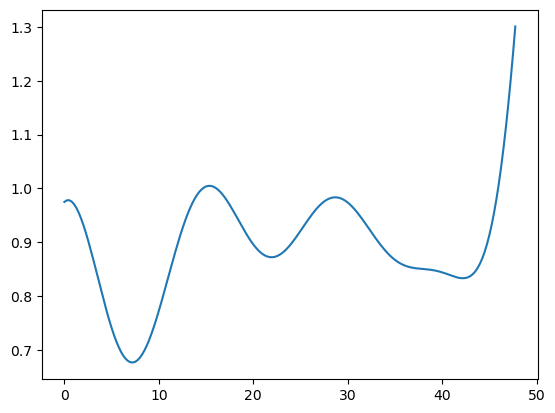

In [44]:
import matplotlib.pyplot as plt

plt.plot(t,ctrls)